<a href="https://colab.research.google.com/github/jimmy-pink/colab-playground/blob/main/pre-trained/VGG16-FruitClassification-WasteClassification-IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P1: Fruit Classification


### Project overview

In this practice project, you will learn to classify images of fruits into different categories using transfer learning. The pre-trained VGG16 model will be used as the base, and custom layers will be added to fine-tune the model for our specific task. This approach allows us to leverage the knowledge learned from a large dataset (ImageNet) and apply it to a smaller, custom dataset with minimal computational resources and data.

### Aim

The aim is to classify images of different fruits using a machine learning model. You will train a convolutional neural network (CNN) to recognize various fruit categories using the power of transfer learning with a pre-trained model.

### Final Output

A trained model capable of classifying fruit images into specified categories with good accuracy.

### Learning objectives

After completing this project, you will be able to:

- Prepare data into a directory structure
- Create sample images
- Verify the directory structure and images
- Set up the data generator
- Build and compile the model
- Train and evaluate the model using callbacks
- Plot and visualize the model

### Prerequisites

- Basic knowledge of Python and Keras
- TensorFlow installed in your Python environment
- A dataset of fruit images organized in subdirectories for each class

### Instructions

You need to perform the following tasks to complete the project after preparing the data:

- Task 1: Print the version of TensorFlow
- Task 2: Create a test generator using the test_datagen object
- Task 3: Print the length of the train generator
- Task 4: Print the summary of the model
- Task 5: Compile the model
- Task 6: Plot accuracy curves for training and validation sets
- Task 7: Plot loss curves for training and validation sets (fine-tuned model)
- Task 8: Plot accuracy curves for training and validation sets (fine-tuned model)
- Task 9: Plot a test image using the Extract Features Model
- Task 10: Plot a test image using the Fine-Tuned Model

### Key Takeaways

Transfer learning enables leveraging pre-trained models for custom tasks with limited data.
Data augmentation helps improve model generalization on small datasets.  

Let's start this guided project and train a convolutional neural network (CNN) to recognize various fruit categories using the power of transfer learning with a pre-trained model.



### 设置环境

In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scikit-learn

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### 数据准备 与 数据增强

```text
dataset/
├── train/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
├── val/
│   ├── Class1/
│   ├── Class2/
│   ├── Class3/
│   └── (other classes...)
└── test/
    ├── Class1/
    ├── Class2/
    ├── Class3/
    └── (other classes...)
```

In [2]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")


# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")


Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


- 导入库

Library Explanations:[](https://jupyterlabnext-2-labs-prod-jupyterlab-us-east-0.labs.cognitiveclass.ai/user/huzhizhaosme/lab/workspaces/auto-G/tree/DL0120EN/Practice%20Project%20Fruit%20Classification%20Using%20TF.ipynb#Library-Explanations:)

- `ImageDataGenerator:` For loading images and applying data augmentation.
- `VGG16:` Pre-trained model used for transfer learning.
- `Sequential:` For building a sequential model.
- `Dense, Flatten, Dropout, BatchNormalization:` Layers to customize the model architecture.
- `ReduceLROnPlateau, EarlyStopping:` Callbacks for optimizing training.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set dataset paths
train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'

2. 数据增强

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='categorical'
)


Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


### 迁移学习

3. 定义模型

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


4. compile model

In [6]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


5. train model

In [7]:
import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy

# Define callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Enable mixed precision (if on GPU)
set_global_policy('float32')

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler, early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.1615 - loss: 3.1780 - val_accuracy: 0.2150 - val_loss: 2.5218 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.4698 - loss: 1.7445 - val_accuracy: 0.3900 - val_loss: 2.0479 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5952 - loss: 1.2888 - val_accuracy: 0.4600 - val_loss: 1.7543 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.6948 - loss: 1.0338 - val_accuracy: 0.5900 - val_loss: 1.4105 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.7288 - loss: 0.9121 - val_accuracy: 0.6550 - val_loss: 1.2579 - learning_rate: 0.0010


6. 模型微调

In [8]:
import tensorflow as tf  # Import TensorFlow for accessing tf.keras
from tensorflow.keras.optimizers import Adam

# Check the number of layers in the base model
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Unfreeze the last 5 layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Re-compile the model with a faster optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),   # Higher learning rate for faster convergence
    metrics=['accuracy']
)

# Continue training with fewer steps per epoch
history_fine = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7172 - loss: 0.8964 - val_accuracy: 0.7550 - val_loss: 0.8044 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7684 - loss: 0.7488 - val_accuracy: 0.8325 - val_loss: 0.6389 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.7921 - loss: 0.6426 - val_accuracy: 0.8850 - val_loss: 0.4203 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.7962 - loss: 0.6034 - val_accuracy: 0.8125 - val_loss: 0.5302 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8551 - loss: 0.4997 - val_accuracy: 0.9150 - val_loss: 0.3731 - learning_rate: 1.0000e-05


7. 评估模型

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f"Test Accuracy: {test_accuracy:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8833 - loss: 0.4110
Test Accuracy: 0.86


8. 可视化

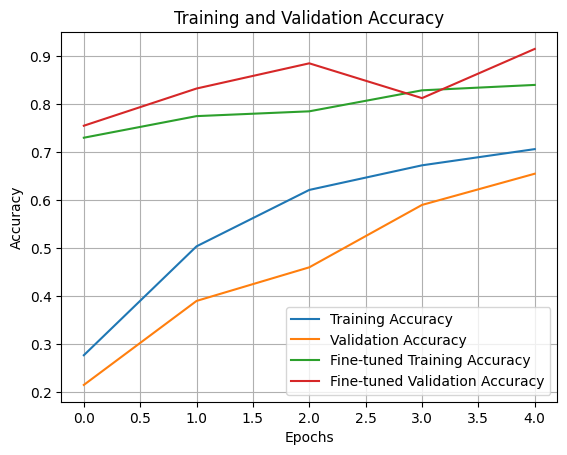

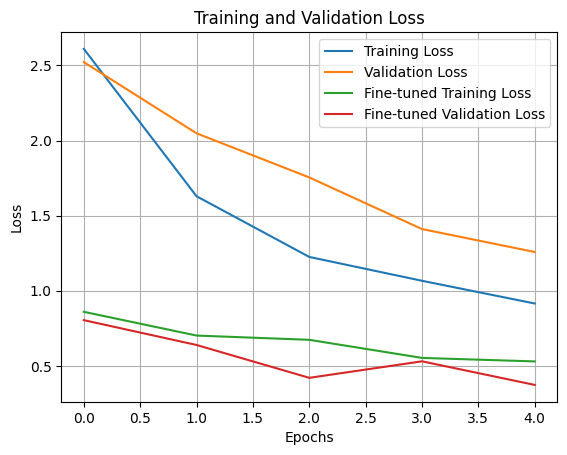

In [10]:
# Plot accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


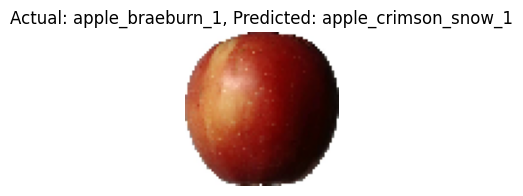

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


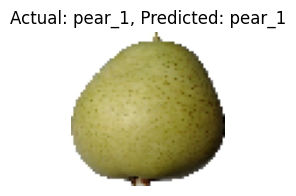

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


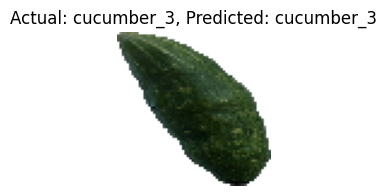

In [11]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)


# P2: Classify Waste Products

Final Project Overview: Classify Waste Products Using Transfer Learning



### Project Scenario

The city of GreenCity has been struggling with waste management, especially in distinguishing between recyclable and organic waste. The local waste management organization, EcoClean, is tasked with improving the efficiency of waste sorting. However, the current manual process is both time-consuming and error-prone. To enhance the system, EcoClean wants you to develop an AI-powered solution that can automatically classify waste products using image recognition techniques. This project aims to build a model that can differentiate between recyclable and organic waste products using transfer learning.

### Project Background

EcoClean currently lacks an efficient and scalable method to automate the waste sorting process. The manual sorting of waste is not only labor-intensive but also prone to errors, leading to contamination of recyclable materials. The goal of this project is to leverage machine learning and computer vision to automate the classification of waste products, improving efficiency and reducing contamination rates. The project will use transfer learning with a pre-trained VGG16 model to classify images.

### Aim

The aim of the project is to develop an automated waste classification model that can accurately differentiate between recyclable and organic waste based on images. By the end of this project, you will have trained, fine-tuned, and evaluated a model using transfer learning, which can then be applied to real-world waste management processes.

Final Output: A trained model that classifies waste images into recyclable and organic categories.

### Learning objectives

After completing this project, you will be able to:

- Apply transfer learning using the VGG16 model for image classification
- Prepare and preprocess image data for a machine learning task
- Fine-tune a pre-trained model to improve classification accuracy
- Evaluate the model's performance using appropriate metrics
- Visualize model predictions on test data
### Instructions

To achieve the above objectives, you will complete the following tasks:

- Task 1: Print the version of TensorFlow
- Task 2: Create a test_generator using the test_datagen object
- Task 3: Print the length of the train_generator
- Task 4: Print the summary of the model
- Task 5: Compile the model
- Task 6: Plot accuracy curves for training and validation sets (extract_feat_model)
- Task 7: Plot loss curves for training and validation sets (fine-tune model)
- Task 8: Plot accuracy curves for training and validation sets (fine-tune model)
- Task 9: Plot a test image using Extract Features Model (index_to_plot = 1)
- Task 10: Plot a test image using Fine-Tuned Model (index_to_plot = 1)
